This notebook follows this [NEON Data Skills Python Tutorial](https://github.com/NEONScience/NEON-Data-Skills/blob/main/tutorials/Python/AOP/Hyperspectral/intro-hyperspectral/intro-refl-h5/intro-l3-refl-h5.md).

Before running this notebook, data needs to be downloaded to your local machine:
From this website: https://data.neonscience.org/data-products/DP3.30006.001/RELEASE-2025, download the reflectance data you want to look at.
I downloaded this NEON zipfile: NEON_D17_SOAP_DP3_298000_4107000_reflectance
This is just for 2019, I believe the data was gathered in June.
There is no provisional data.
Since this NEON Data Skills tutorial did not include unzipping a path, I copied just the NEON_D17_SOAP_DP3_298000_4107000_reflectance.h5 file from my local downloads folder to the data folder I made for this notebook, 03_data

Data citation:

NEON (National Ecological Observatory Network). Spectrometer orthorectified surface directional reflectance - mosaic (DP3.30006.001), RELEASE-2025. https://doi.org/10.48443/49kq-8q12. Dataset accessed from https://data.neonscience.org/data-products/DP3.30006.001/RELEASE-2025 on April 28, 2025.

In [1]:
#import required packages
import os
import requests
import numpy as np
import h5py
from osgeo import gdal
import matplotlib.pyplot as plt

## Read in the datasets

In [2]:
# display the contents in the ./data folder to confirm the download completed
# my data folder is called 03_data, change as necessary for your machine
os.listdir('./03_data')

['NEON_D17_SOAP_DP3_298000_4107000_reflectance.h5']

I got this error when I ran the cell below: NotADirectoryError: [WinError 267] The directory name is invalid: './data/NEON_refl-surf-dir-ortho-mosaic.zip'.
I assume this is because it is a zip file.
To get around this for now, I moved the hdf5 file to the data folder

In [3]:
# display the contents in the ./data/NEON_refl-surf-dir-ortho-mosaic.zip folder to confirm the download completed
#os.listdir('./data/NEON_refl-surf-dir-ortho-mosaic.zip')

In [4]:
# display the contents in the ./data folder to confirm the hdf5 file moved correctly
os.listdir('./03_data')

['NEON_D17_SOAP_DP3_298000_4107000_reflectance.h5']

## Read in the hdf5 file

In [5]:
# see what the h5py function does
help(h5py)

Help on package h5py:

NAME
    h5py

DESCRIPTION
    This is the h5py package, a Python interface to the HDF5
    scientific data format.

PACKAGE CONTENTS
    _conv
    _errors
    _hl (package)
    _objects
    _proxy
    _selector
    defs
    h5
    h5a
    h5ac
    h5d
    h5ds
    h5f
    h5fd
    h5g
    h5i
    h5l
    h5o
    h5p
    h5pl
    h5py_warnings
    h5r
    h5s
    h5t
    h5z
    ipy_completer
    tests (package)
    utils
    version

SUBMODULES
    filters

FUNCTIONS
    enable_ipython_completer()
        Call this from an interactive IPython session to enable tab-completion
        of group and attribute names.
    
    run_tests(args='')
        Run tests with pytest and returns the exit status as an int.

DATA
    UNLIMITED = 18446744073709551615
    ref_dtype = dtype('O')
    regionref_dtype = dtype('O')

VERSION
    3.13.0

FILE
    c:\users\riede\anaconda3\envs\lpdaac_vitals\lib\site-packages\h5py\__init__.py




In [6]:
# learn about h5py.File
h5py.File?

Init signature:
h5py.File(
    name,
    mode='r',
    driver=None,
    libver=None,
    userblock_size=None,
    swmr=False,
    rdcc_nslots=None,
    rdcc_nbytes=None,
    rdcc_w0=None,
    track_order=None,
    fs_strategy=None,
    fs_persist=False,
    fs_threshold=1,
    fs_page_size=None,
    page_buf_size=None,
    min_meta_keep=0,
    min_raw_keep=0,
    locking=None,
    alignment_threshold=1,
    alignment_interval=1,
    meta_block_size=None,
    **kwds,
)
Docstring:      Represents an HDF5 file.
Init docstring:
Create a new file object.

See the h5py user guide for a detailed explanation of the options.

name
    Name of the file on disk, or file-like object.  Note: for files
    created with the 'core' driver, HDF5 still requires this be
    non-empty.
mode
    r        Readonly, file must exist (default)
    r+       Read/write, file must exist
    w        Create file, truncate if exists
    w- or x  Create file, fail if exists
    a        Read/write if exists, create 

In [7]:
# Read the NEON_D17_SOAP_DP3_298000_4107000_reflectance.h5 file to variable f
# Note that you may need to update this filepath for your local machine
# the 'r' indicates that this is in readonly mode
f = h5py.File('./03_data/NEON_D17_SOAP_DP3_298000_4107000_reflectance.h5','r')

# check file
f

<HDF5 file "NEON_D17_SOAP_DP3_298000_4107000_reflectance.h5" (mode r)>

## Explore NEON AOP HDF5 Reflectance Files

In [8]:
#list_dataset lists the names & locations of datasets in an hdf5 file
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

#.visititems lets us look inside the HDF5 dataset
f.visititems(list_dataset)

SOAP/Reflectance/Metadata/Ancillary_Imagery/Aerosol_Optical_Depth
SOAP/Reflectance/Metadata/Ancillary_Imagery/Aspect
SOAP/Reflectance/Metadata/Ancillary_Imagery/Cast_Shadow
SOAP/Reflectance/Metadata/Ancillary_Imagery/Dark_Dense_Vegetation_Classification
SOAP/Reflectance/Metadata/Ancillary_Imagery/Data_Selection_Index
SOAP/Reflectance/Metadata/Ancillary_Imagery/Haze_Cloud_Water_Map
SOAP/Reflectance/Metadata/Ancillary_Imagery/Illumination_Factor
SOAP/Reflectance/Metadata/Ancillary_Imagery/Path_Length
SOAP/Reflectance/Metadata/Ancillary_Imagery/Sky_View_Factor
SOAP/Reflectance/Metadata/Ancillary_Imagery/Slope
SOAP/Reflectance/Metadata/Ancillary_Imagery/Smooth_Surface_Elevation
SOAP/Reflectance/Metadata/Ancillary_Imagery/Visibility_Index_Map
SOAP/Reflectance/Metadata/Ancillary_Imagery/Water_Vapor_Column
SOAP/Reflectance/Metadata/Ancillary_Imagery/Weather_Quality_Indicator
SOAP/Reflectance/Metadata/Coordinate_System/Coordinate_System_String
SOAP/Reflectance/Metadata/Coordinate_System/EPSG C

*from the tutorial:*

>You can see that there is a lot of information stored inside this reflectance hdf5 file. Most of this information is metadata (data about the reflectance data), for example, this file stores input parameters used in the atmospheric correction. For this introductory lesson, we will only work with two of these datasets, the reflectance data (hyperspectral cube), and the corresponding geospatial information, stored in Metadata/Coordinate_System:

> * SERC/Reflectance/Reflectance_Data
>   
> * SERC/Reflectance/Metadata/Coordinate_System/

> We can also display the name, shape, and type of each of these datasets using the ls_dataset function defined below, which is also called with the visititems method:

In [9]:
#ls_dataset displays the name, shape, and type of datasets in hdf5 file
def ls_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(node)

In [10]:
# call the ls_dataset fxn with .visititems
f.visititems(ls_dataset)

<HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
<HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
<HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
<HDF5 dataset "Dark_Dense_Vegetation_Classification": shape (1000, 1000), type "|u1">
<HDF5 dataset "Data_Selection_Index": shape (1000, 1000), type "<i4">
<HDF5 dataset "Haze_Cloud_Water_Map": shape (1000, 1000), type "|u1">
<HDF5 dataset "Illumination_Factor": shape (1000, 1000), type "|u1">
<HDF5 dataset "Path_Length": shape (1000, 1000), type "<f4">
<HDF5 dataset "Sky_View_Factor": shape (1000, 1000), type "|u1">
<HDF5 dataset "Slope": shape (1000, 1000), type "<f4">
<HDF5 dataset "Smooth_Surface_Elevation": shape (1000, 1000), type "<f4">
<HDF5 dataset "Visibility_Index_Map": shape (1000, 1000), type "|u1">
<HDF5 dataset "Water_Vapor_Column": shape (1000, 1000), type "<f4">
<HDF5 dataset "Weather_Quality_Indicator": shape (1000, 1000, 3), type "|u1">
<HDF5 dataset "Coordinate_System_String": shap

## Extract the reflectance data
The reflectance data is nested under SOAP/Reflectance/Reflectance_Data:

In [11]:
# write the SOAP reflectance data to a variable
soap_refl = f['SOAP']['Reflectance']

# check variable
print(soap_refl)

<HDF5 group "/SOAP/Reflectance" (2 members)>


2 members = Metadata and Reflectance_Data.

We will save reflectance data as soap_reflarray

In [12]:
# save just the SOAP reflectance data
soap_reflarray = soap_refl['Reflectance_Data']

# check variable
print(soap_reflarray)

<HDF5 dataset "Reflectance_Data": shape (1000, 1000, 426), type "<i2">


Use shape method to extract the size of this reflectance array:

In [13]:
# extract size of reflectance array
refl_shape = soap_reflarray.shape
print('SOAP Reflectance Data Dimensions:',refl_shape)

SOAP Reflectance Data Dimensions: (1000, 1000, 426)


This is a 3D shape. The three dimensions are (y,x,bands).

(x,y) are dimensions of the reflectance array in pixels. 

*from the tutorial:*

>"Hyperspectral data sets are often called "cubes" to reflect this 3-dimensional shape."
>
>"NEON hyperspectral data contain around 426 spectral bands, and when working with tiled data, the spatial dimensions are 1000 x 1000, where each pixel represents 1 meter."

## Explore Wavelength Values

Start by extracting wavelength info from soap_refl

In [14]:
#define the wavelengths variable
wavelengths = soap_refl['Metadata']['Spectral_Data']['Wavelength']

#View wavelength information and values
print('wavelengths:',wavelengths)

wavelengths: <HDF5 dataset "Wavelength": shape (426,), type "<f4">


Use numpy to see min and max wavelength values:

In [15]:
# Display min & max wavelengths
print('min wavelength:', np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

min wavelength: 381.5437 nm
max wavelength: 2509.932 nm


Find band widths (the distance btw center bands of two adjacent bands). We will do this for the first and last two bands.

*from the tutorial:*

>Remember that Python uses 0-based indexing ([0] represents the first value in an array), and note that you can also use negative numbers to splice values from the end of an array ([-1] represents the last value in an array).

In [16]:
#show the band widths between the first 2 bands and last 2 bands 
print('band width between first 2 bands =',(wavelengths[1]-wavelengths[0]),'nm')
print('band width between last 2 bands =',(wavelengths[-1]-wavelengths[-2]),'nm')

band width between first 2 bands = 5.0079956 nm
band width between last 2 bands = 5.0080566 nm


*from the tutorial:*

>The center wavelengths recorded in this hyperspectral cube range from 383.88 - 2512.18 nm, and each band covers a range of ~5 nm. Now let's extract spatial information, which is stored under SOAP/Reflectance/Metadata/Coordinate_System/Map_Info:

In [17]:
# extract spatial info from SOAP Reflectance Metadata
soap_mapInfo = soap_refl['Metadata']['Coordinate_System']['Map_Info']

# check spatial info
print('SOAP Map Info:',soap_mapInfo)

SOAP Map Info: <HDF5 dataset "Map_Info": shape (), type "|O">


In [18]:
# see components of SOAP reflectance spatial info
soap_mapInfo[()]

b'UTM,  1.000,  1.000,       298000.00,       4108000.0,       1.0000000,       1.0000000,  11,  North,  WGS-84,  units=Meters, 0'

The cell above yields spatial info abt the reflectance data:

* UTM = CRS
* 1.000, 1.000 - not sure what these are
* 298000.00, 4108000.0 - UTM coordinates (in meters) of the map origin, which refers to the upper-left corner of the image (xMin, yMax)
* 1.0000000, 1.0000000 - pixel resolution in meters
* 11 = UTM zone
* North = UTM Hemisphere (All NEON sites are N)
* WGS-84 = reference ellipoid



*from the tutorial:*

>Note that the letter b that appears before UTM signifies that the variable-length string data is stored in binary format when it is written to the hdf5 file. Don't worry about it for now, as we will convert the numerical data we need into floating point numbers. For more information on hdf5 strings read the h5py documentation.
>
> You can display this in as a string as follows:
> serc_mapInfo[()].decode("utf-8")
>
>Let's extract relevant information from the Map_Info metadata to define the spatial extent of this dataset. To do this, we can use the split method to break up this string into separate values:

In [19]:
#First convert mapInfo to a string
mapInfo_string = soap_mapInfo[()].decode("utf-8") # read in as string

In [20]:
#split the strings using the separator "," 
mapInfo_split = mapInfo_string.split(",") 
print(mapInfo_split)

['UTM', '  1.000', '  1.000', '       298000.00', '       4108000.0', '       1.0000000', '       1.0000000', '  11', '  North', '  WGS-84', '  units=Meters', ' 0']


By doing that, we can extract spatial info from map info values and convert them to the float data type and store them so we can access and apply them later when we want to plot the data:

In [21]:
#Extract the resolution & convert to floating decimal number
res = float(mapInfo_split[5]),float(mapInfo_split[6])
print('Resolution:',res)

Resolution: (1.0, 1.0)


In [22]:
#Extract the upper left-hand corner coordinates from mapInfo
xMin = float(mapInfo_split[3]) 
yMax = float(mapInfo_split[4])

#Calculate the xMax and yMin values from the dimensions
xMax = xMin + (refl_shape[1]*res[0]) #xMax = left edge + (# of columns * x pixel resolution)
yMin = yMax - (refl_shape[0]*res[1]) #yMin = top edge - (# of rows * y pixel resolution)

Next, we will define the spatial extent as a tuple (xMin, xMax, yMin, yMax) as this format is needed to apply the spatial extent when plotting w/ matplotlib.pyplot.

In [23]:
#Define extent as a tuple:
soap_ext = (xMin, xMax, yMin, yMax)
print('soap_ext:',soap_ext)
print('soap_ext type:',type(soap_ext))

soap_ext: (298000.0, 299000.0, 4107000.0, 4108000.0)
soap_ext type: <class 'tuple'>


## Extract a Single Band from Array
We will extract a single band that represents a 5nm band (about) that approximates a single wavelength. This band is going to be extracted from the hyperspectral cube using splicing.

The band we extract will be a 2D array that is 1000 x 1000. This array is the scaled reflectance data corresponding to wavelength band 56 (55 in the code as Python indexing starts at 0).

We first have to cast the reflectance data into float values.

In [24]:
# save a single band of the SOAP reflectance array
b56 = soap_reflarray[:,:,55].astype(float)

# check band variable & view band metadata
print('b56 type:',type(b56))
print('b56 shape:',b56.shape)
print('Band 56 Reflectance:\n',b56)

b56 type: <class 'numpy.ndarray'>
b56 shape: (1000, 1000)
Band 56 Reflectance:
 [[1340. 1188.  870. ...  862.  480.  551.]
 [1019.  792. 1213. ...  822.  659.  535.]
 [1164.  926.  766. ...  493.  730.  820.]
 ...
 [ 257.  122.  198. ...  166.  245.  313.]
 [ 290.  137.  151. ...   83.  163.  431.]
 [ 119.  166.  195. ...  117.  124.  215.]]


## Clean the single band: Scale factor and No Data Value

NEON AOP reflectance data uses a Data_Ignore_Value of -9999 to represent NaN values and a reflectance Scale_Factor of 10000.0 to save disk space.

Extract & apply the Data_Ignore_Value and Scale_Factor:

In [27]:
#View scale factor and data ignore value
scaleFactor = soap_reflarray.attrs['Scale_Factor']
noDataValue = soap_reflarray.attrs['Data_Ignore_Value']
print('Scale Factor:',scaleFactor)
print('Data Ignore Value:',noDataValue)

# apply scale factor and data ignore value
b56[b56==int(noDataValue)]=np.nan
b56 = b56/scaleFactor
print('Cleaned Band 56 Reflectance:\n',b56)

Scale Factor: 10000.0
Data Ignore Value: -9999.0
Cleaned Band 56 Reflectance:
 [[1.340e-05 1.188e-05 8.700e-06 ... 8.620e-06 4.800e-06 5.510e-06]
 [1.019e-05 7.920e-06 1.213e-05 ... 8.220e-06 6.590e-06 5.350e-06]
 [1.164e-05 9.260e-06 7.660e-06 ... 4.930e-06 7.300e-06 8.200e-06]
 ...
 [2.570e-06 1.220e-06 1.980e-06 ... 1.660e-06 2.450e-06 3.130e-06]
 [2.900e-06 1.370e-06 1.510e-06 ... 8.300e-07 1.630e-06 4.310e-06]
 [1.190e-06 1.660e-06 1.950e-06 ... 1.170e-06 1.240e-06 2.150e-06]]


## Plot single reflectance band

Use matplotlib.pyplot (plt). Default colormap is jet, different colormaps [here](https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html).

Text(0, 0.5, 'y')

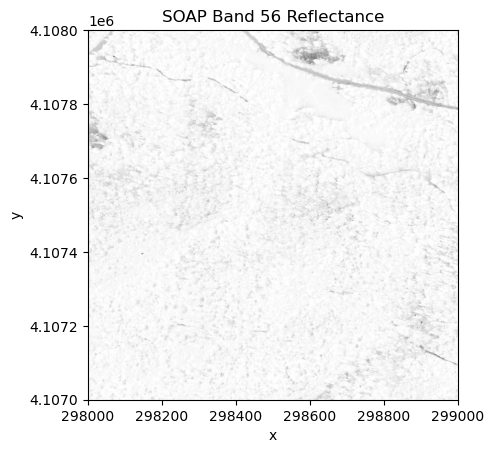

In [47]:
# plot band 56 of the SOAP reflectance data
soap_56_plot = plt.imshow(b56,extent=soap_ext,cmap='Greys')
# add title
plt.title('SOAP Band 56 Reflectance')
plt.xlabel("x")
plt.ylabel("y")

Since this image is sort of washed out, we can look at range and distribution of reflectance values that are being plotted w/ a histogram.

## Plot histogram

Use matplotlib.pyplot.hist fxn. This fxn doesn't work if there are NaN values so the code below ignores NaN values.

Text(0, 0.5, 'frequency')

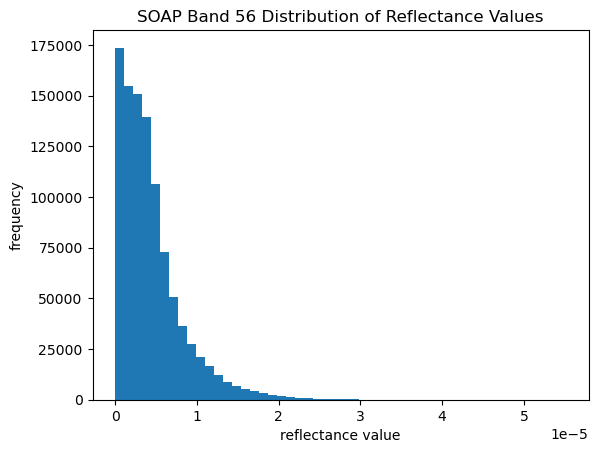

In [67]:
# create histogram of band reflectance values to see range & distribution
plt.hist(b56[~np.isnan(b56)],50); #50 signifies the # of bins
plt.title("SOAP Band 56 Distribution of Reflectance Values")
plt.xlabel("reflectance value")
plt.ylabel("frequency")

Most of the reflectance values are less than 0.2. To show more contrast, adjust the colorlimit (clim) to 0-0.2:

Text(0, 0.5, 'y')

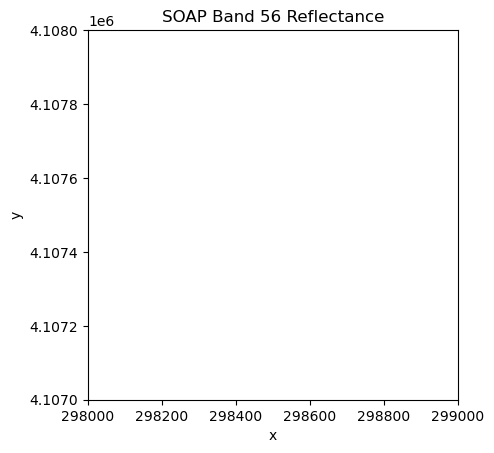

In [49]:
# create plot of band 56
soap_56_plot = plt.imshow(b56,extent=soap_ext,cmap='Greys',clim=(0,0.2)) 
#add title
plt.title('SOAP Band 56 Reflectance');
plt.xlabel("x")
plt.ylabel("y")

## Extract band 53 (index 52)

This band is either red, blue, or green.

In [50]:
# save a single band of the SOAP reflectance array
b53 = soap_reflarray[:,:,52].astype(float)

# check band variable & view band metadata
print('b53 type:',type(b53))
print('b53 shape:',b53.shape)
print('Band 53 Reflectance:\n',b53)

b53 type: <class 'numpy.ndarray'>
b53 shape: (1000, 1000)
Band 53 Reflectance:
 [[1310. 1153.  864. ...  908.  482.  576.]
 [1008.  784. 1226. ...  874.  700.  540.]
 [1165.  916.  749. ...  548.  783.  871.]
 ...
 [ 273.  134.  235. ...  181.  272.  330.]
 [ 322.  139.  172. ...  100.  191.  460.]
 [ 133.  171.  217. ...  133.  147.  233.]]


In [51]:
# clean band 53
#View scale factor and data ignore value - commented out as this was done above
# scaleFactor = soap_reflarray.attrs['Scale_Factor']
# noDataValue = soap_reflarray.attrs['Data_Ignore_Value']
# print('Scale Factor:',scaleFactor)
# print('Data Ignore Value:',noDataValue)

# apply scale factor and data ignore value
b53[b53==int(noDataValue)]=np.nan
b53 = b53/scaleFactor
print('Cleaned Band 53 Reflectance:\n',b53)

Cleaned Band 53 Reflectance:
 [[0.131  0.1153 0.0864 ... 0.0908 0.0482 0.0576]
 [0.1008 0.0784 0.1226 ... 0.0874 0.07   0.054 ]
 [0.1165 0.0916 0.0749 ... 0.0548 0.0783 0.0871]
 ...
 [0.0273 0.0134 0.0235 ... 0.0181 0.0272 0.033 ]
 [0.0322 0.0139 0.0172 ... 0.01   0.0191 0.046 ]
 [0.0133 0.0171 0.0217 ... 0.0133 0.0147 0.0233]]


Text(0, 0.5, 'y')

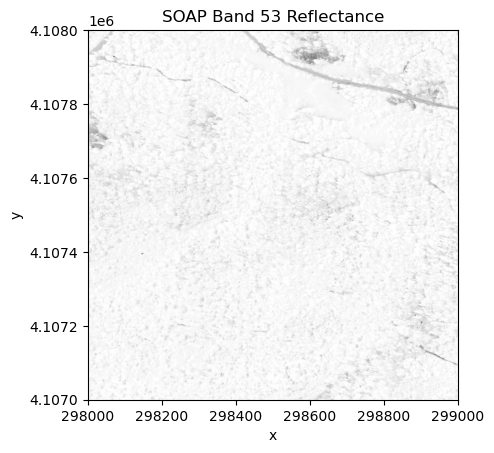

In [52]:
# Create plot of band 53
soap_53_plot = plt.imshow(b53,extent=soap_ext,cmap='Greys') 
plt.title('SOAP Band 53 Reflectance');
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'frequency')

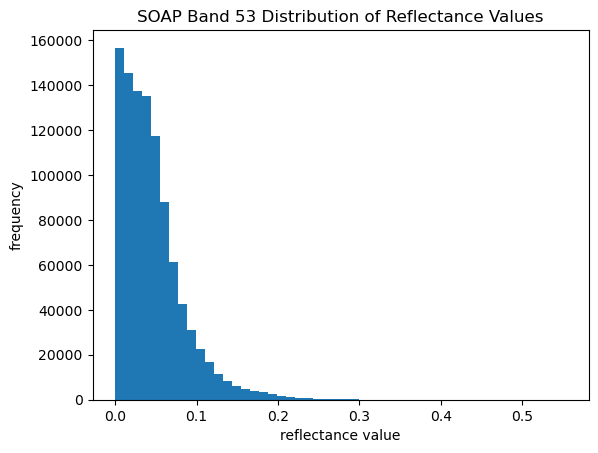

In [68]:
# create histogram of band reflectance values to see range & distribution
plt.hist(b53[~np.isnan(b53)],50); #50 signifies the # of bins
plt.title("SOAP Band 53 Distribution of Reflectance Values")
plt.xlabel("reflectance value")
plt.ylabel("frequency")

Text(0, 0.5, 'y')

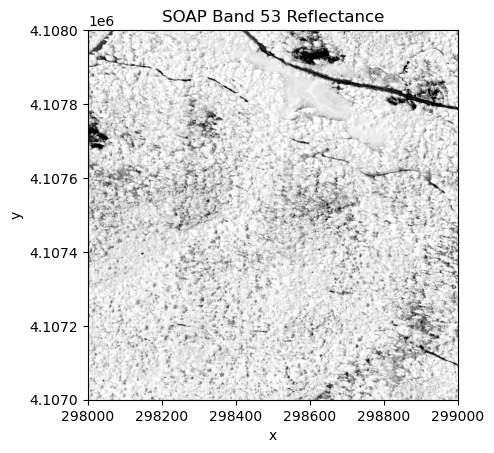

In [54]:
# adjust color limit on plot
soap_53_plot = plt.imshow(b53,extent=soap_ext,cmap='Greys',clim=(0,0.2)) 
plt.title('SOAP Band 53 Reflectance');
plt.xlabel("x")
plt.ylabel("y")

## Extract band 35 (index 34)

Either red, blue, or green

In [55]:
# save a single band of the SOAP reflectance array
b35 = soap_reflarray[:,:,34].astype(float)

# check band variable & view band metadata
print('b35 type:',type(b35))
print('b53 shape:',b35.shape)
print('Band 35 Reflectance:\n',b35)

b35 type: <class 'numpy.ndarray'>
b53 shape: (1000, 1000)
Band 35 Reflectance:
 [[1102.  943.  830. ...  914.  512.  550.]
 [ 795.  861. 1062. ...  949.  759.  589.]
 [ 953.  747.  726. ...  655.  881. 1025.]
 ...
 [ 362.  193.  353. ...  291.  371.  437.]
 [ 427.  185.  235. ...  174.  283.  645.]
 [ 177.  221.  302. ...  239.  240.  313.]]


In [56]:
# clean band 35
#View scale factor and data ignore value - commented out as this was done above
# scaleFactor = soap_reflarray.attrs['Scale_Factor']
# noDataValue = soap_reflarray.attrs['Data_Ignore_Value']
# print('Scale Factor:',scaleFactor)
# print('Data Ignore Value:',noDataValue)

# apply scale factor and data ignore value
b35[b35==int(noDataValue)]=np.nan
b35 = b35/scaleFactor
print('Cleaned Band 35 Reflectance:\n',b35)

Cleaned Band 35 Reflectance:
 [[0.1102 0.0943 0.083  ... 0.0914 0.0512 0.055 ]
 [0.0795 0.0861 0.1062 ... 0.0949 0.0759 0.0589]
 [0.0953 0.0747 0.0726 ... 0.0655 0.0881 0.1025]
 ...
 [0.0362 0.0193 0.0353 ... 0.0291 0.0371 0.0437]
 [0.0427 0.0185 0.0235 ... 0.0174 0.0283 0.0645]
 [0.0177 0.0221 0.0302 ... 0.0239 0.024  0.0313]]


Text(0, 0.5, 'y')

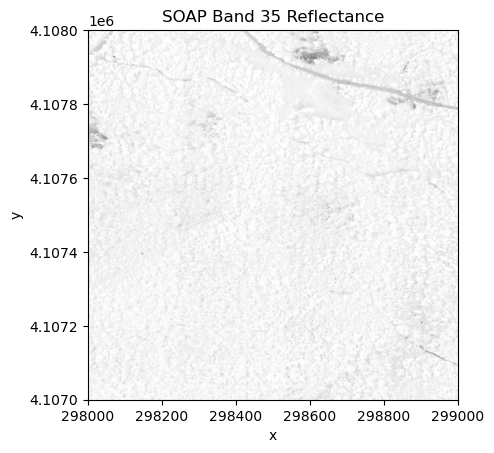

In [57]:
# create plot of band 35
soap_35_plot = plt.imshow(b35,extent=soap_ext,cmap='Greys') 
plt.title('SOAP Band 35 Reflectance');
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'frequency')

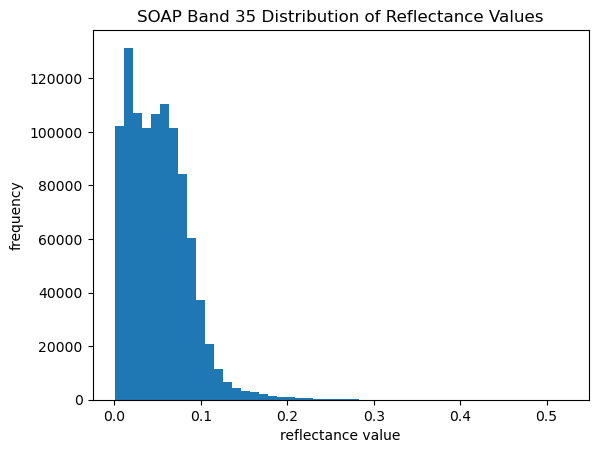

In [69]:
# create histogram of band reflectance values to see range & distribution
plt.hist(b35[~np.isnan(b35)],50); #50 signifies the # of bins
plt.title("SOAP Band 35 Distribution of Reflectance Values")
plt.xlabel("reflectance value")
plt.ylabel("frequency")

Text(0, 0.5, 'y')

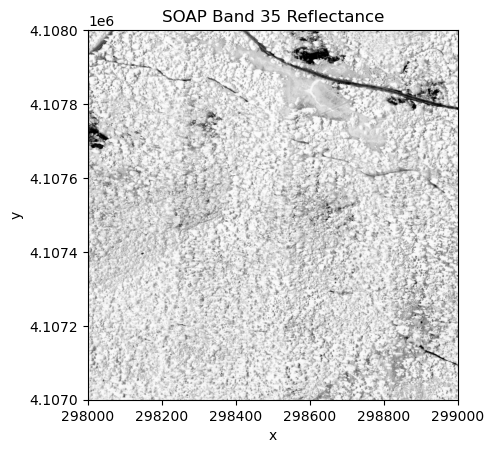

In [59]:
# adjust color limit on plot
soap_35_plot = plt.imshow(b35,extent=soap_ext,cmap='Greys',clim=(0,0.2)) 
plt.title('SOAP Band 35 Reflectance');
plt.xlabel("x")
plt.ylabel("y")

## Extract band 19 (index 18)

Either red, blue, or green

In [60]:
# save a single band of the SOAP reflectance array
b19 = soap_reflarray[:,:,18].astype(float)

# check band variable & view band metadata
print('b19 type:',type(b19))
print('b19 shape:',b19.shape)
print('Band 19 Reflectance:\n',b19)

b19 type: <class 'numpy.ndarray'>
b19 shape: (1000, 1000)
Band 19 Reflectance:
 [[756. 617. 485. ... 549. 320. 356.]
 [583. 476. 653. ... 573. 506. 400.]
 [704. 533. 469. ... 387. 552. 546.]
 ...
 [204. 133. 170. ... 151. 194. 241.]
 [208. 124. 133. ... 106. 159. 341.]
 [113. 143. 161. ... 137. 138. 197.]]


In [61]:
# clean band 35
#View scale factor and data ignore value - commented out as this was done above
# scaleFactor = soap_reflarray.attrs['Scale_Factor']
# noDataValue = soap_reflarray.attrs['Data_Ignore_Value']
# print('Scale Factor:',scaleFactor)
# print('Data Ignore Value:',noDataValue)

# apply scale factor and data ignore value
b19[b35==int(noDataValue)]=np.nan
b19 = b19/scaleFactor
print('Cleaned Band 19 Reflectance:\n',b19)

Cleaned Band 19 Reflectance:
 [[0.0756 0.0617 0.0485 ... 0.0549 0.032  0.0356]
 [0.0583 0.0476 0.0653 ... 0.0573 0.0506 0.04  ]
 [0.0704 0.0533 0.0469 ... 0.0387 0.0552 0.0546]
 ...
 [0.0204 0.0133 0.017  ... 0.0151 0.0194 0.0241]
 [0.0208 0.0124 0.0133 ... 0.0106 0.0159 0.0341]
 [0.0113 0.0143 0.0161 ... 0.0137 0.0138 0.0197]]


Text(0, 0.5, 'y')

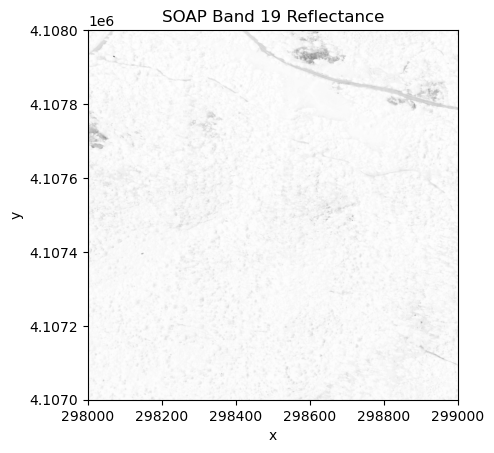

In [62]:
# create plot of band 19
soap_19_plot = plt.imshow(b19,extent=soap_ext,cmap='Greys') 
plt.title('SOAP Band 19 Reflectance')
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'frequency')

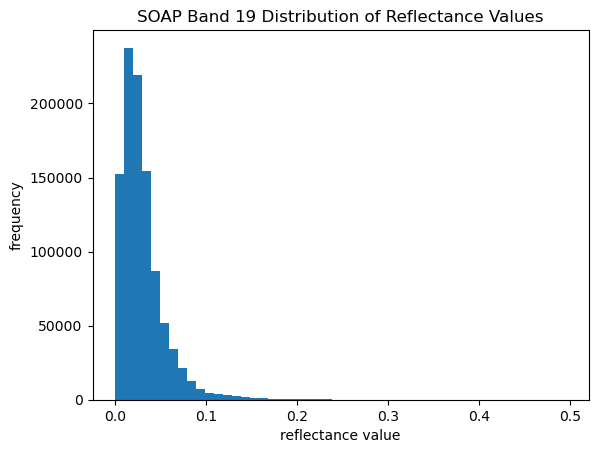

In [70]:
# create histogram of band reflectance values to see range & distribution
plt.hist(b19[~np.isnan(b19)],50); #50 signifies the # of bins
plt.title("SOAP Band 19 Distribution of Reflectance Values")
plt.xlabel("reflectance value")
plt.ylabel("frequency")

Text(0, 0.5, 'y')

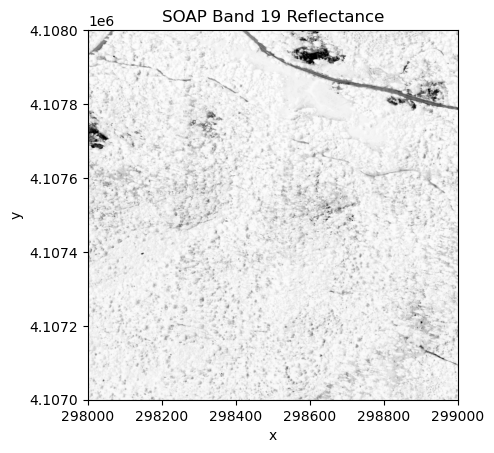

In [64]:
# adjust color limit on band 19 plot
soap_19_plot = plt.imshow(b19,extent=soap_ext,cmap='Greys',clim=(0,0.2)) 
plt.title('SOAP Band 19 Reflectance');
plt.xlabel("x")
plt.ylabel("y")